In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('MBB.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [3]:
df

,Price
0,11783.9
1,12267.4
2,12267.4
3,12307.6
4,12448.7
...,...
1237,18850.0
1238,18800.0
1239,18450.0
1240,18600.0


In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=10721.475, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=10465.709, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=10212.189, Time=0.23 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=10213.910, Time=0.50 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=10213.944, Time=0.43 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 3.480 seconds


ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [7]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val = model.predict(n_periods=len(y_val))

In [8]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[21515.54645562 21580.49291125 21645.43936687 21710.38582249
 21775.33227811 21840.27873374 21905.22518936 21970.17164498
 22035.1181006  22100.06455623 22165.01101185 22229.95746747
 22294.90392309 22359.85037872 22424.79683434 22489.74328996
 22554.68974559 22619.63620121 22684.58265683 22749.52911245
 22814.47556808 22879.4220237  22944.36847932 23009.31493494
 23074.26139057 23139.20784619 23204.15430181 23269.10075743
 23334.04721306 23398.99366868]


In [9]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

valid_mape = np.mean(np.abs((y_pred_val - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 7868.598580971952
Testing RMSE: 13470.407656836529
Validation MAPE: 42.257985130667066
Testing MAPE: 50.09897181075681
Validation MAE: 7578.626704227083
Testing MAE: 10669.25523374913


Validation RMSE: 7868.598580971952
Testing RMSE: 13470.407656836529


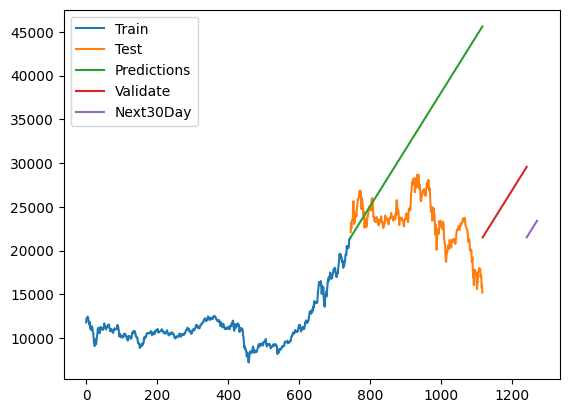

In [10]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()